# Modèle final
Il s'agit du modèle regroupant tous les essais faits dans les notebooks précédents. Dans celui-ci, il s'agit de faire la prédiction d'une réponsemulti-classes, à partir des textes des réponses ouvertes et du code postal du contributeur. 

## Imports

In [231]:
import csv, sys
import tensorflow as tf
%env TF_FORCE_GPU_ALLOW_GROWTH=true
# %matplotlib widget
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
from keras.layers import TextVectorization, Concatenate
from keras.optimizers import Adam
from keras_tuner import HyperParameters, RandomSearch

env: TF_FORCE_GPU_ALLOW_GROWTH=true


## Récupération et préparation des données

### Lecture du CSV et récupération des données

In [232]:
csv.field_size_limit(sys.maxsize)

# liste des catégories pour la classification multi-classes
liste = ["Les dérèglements climatiques (crue, sécheresse)", "La pollution de l'air", "La biodiversité et la disparition de certaines espèces", "L'érosion du littoral"]

with open("./LA_TRANSITION_ECOLOGIQUE.csv") as f:
    reader = csv.reader(f)
    header = next(reader)
    label = []
    text = []
    # deux choix de modélisation possibles pour le deuxième input: code postal ou département
    postcode = []
    departement = []
    # récupération des informations seulement pour les lignes complètes (avec toutes les colonnes remplies)
    for row in reader:
        if row[12] != '' and  row[17] != '' and  row[18] != '' and row[24] != '' and row[25] != '' and row[26] != ''  and row[11] in liste and row[10] != '': 
            text.append(row[12] + " "+ row[17] + " "+ row[18] + " "+ row[24] + " "+ row[25]  + " "+ row[26]  ), label.append(row[11])
            departement.append(row[10][:2])
            postcode.append(row[10])
print(len(text))

37857


### Initialisation de la couche TextVectorization

In [233]:
text_vectorizer = TextVectorization(max_tokens=800,
                                            output_sequence_length=800,
                                            standardize='lower_and_strip_punctuation',
                                            split='whitespace',
                                            output_mode='int')

In [234]:
text_vectorizer.adapt(text)

### Séparation en trois jeu de données (train/dev/test)

In [235]:
# découpage des données en train, dev et test
X_traindev_raw, X_test_raw, Y_traindev_raw, Y_test_raw = train_test_split(text, label, train_size=0.8, test_size=0.2, shuffle=False)
X_train_raw, X_dev_raw, Y_train_raw, Y_dev_raw = train_test_split(X_traindev_raw, Y_traindev_raw, train_size=0.8, test_size=0.2, shuffle=False)

In [236]:
# découpage du deuxième input(code postal) selon le découpage des autres données
X2_train = postcode[:len(X_train_raw)]
X2_dev = postcode[len(X_train_raw):len(X_dev_raw)+len(X_train_raw)]
X2_test = postcode[(len(X_dev_raw)+len(X_train_raw)):(len(X_dev_raw)+len(X_train_raw)+len(X_test_raw))]

### Encodage des données sous forme d'array

In [237]:
# encodage des labels sous forme de one-hot vector et transformation des listes en array
from keras.utils import to_categorical
dico_labels = {"Les dérèglements climatiques (crue, sécheresse)": 0, "La pollution de l'air": 1, "La biodiversité et la disparition de certaines espèces": 2, "L'érosion du littoral": 3}

training_data = np.array(X_train_raw)
training_labels = np.array([dico_labels[d] for d in Y_train_raw])
Y_train_ok = to_categorical(training_labels,num_classes=4, dtype='float32')
X2_train_ok2 = np.array(X2_train).astype("float32")

dev_data = np.array(X_dev_raw)
dev_labels = np.array([dico_labels[d] for d in Y_dev_raw])
Y_dev_ok = to_categorical(dev_labels, num_classes=4, dtype='float32')
X2_dev_ok2 = np.array(X2_dev).astype("float32")

testing_data = np.array(X_test_raw)
testing_labels = np.array([dico_labels[d] for d in Y_test_raw])
Y_test_ok = to_categorical(testing_labels, num_classes=4, dtype='float32')
X2_test_ok2 = np.array(X2_test).astype('float32')

In [238]:
# vectorisation des données textuelles
X_train_ok = text_vectorizer(training_data)
X_dev_ok = text_vectorizer(dev_data)
X_test_ok = text_vectorizer(testing_data)
print(X_train_ok.shape, X_dev_ok.shape, X_test_ok.shape)

(24228, 800) (6057, 800) (7572, 800)


### Ajout de dimensions à l'input 2 (code postal)

In [239]:
# ajout artificiel de deux dimensions au deuxième input (code postal) en remplissant avec des 0
X2train1 = X2_train_ok2[..., np.newaxis]
X2train1.shape
X2dev1 = X2_dev_ok2[..., np.newaxis]
X2test1 = X2_test_ok2[..., np.newaxis]

In [240]:
X2_train_padded = np.pad(X2train1, [(0, 0),(0, text_vectorizer.vocabulary_size()-1)], mode='constant')
X2_dev_padded = np.pad(X2dev1, [(0, 0),(0, text_vectorizer.vocabulary_size()-1)], mode='constant')
X2_test_padded = np.pad(X2test1, [(0, 0),(0, text_vectorizer.vocabulary_size()-1)], mode='constant')

In [241]:
print(X2_train_padded.shape)

(24228, 800)


In [242]:
X2_train_repeated1 = np.repeat(X2_train_padded[..., np.newaxis], 64, axis=-1)
X2_dev_repeated1 = np.repeat(X2_dev_padded[..., np.newaxis], 64, axis=-1)
X2_test_repeated1 = np.repeat(X2_test_padded[..., np.newaxis], 64, axis=-1)

In [243]:
print(X2_train_repeated1.shape)

(24228, 800, 64)


## Construction du modèle

## Modèle 1 : Perceptron

In [244]:
def build_model(tv): 
      inputs1 = keras.layers.Input(shape=(tv.vocabulary_size(),))
      embeddings = keras.layers.Embedding(tv.vocabulary_size(),
                                        output_dim=64,
                                        name='emb'
                                       )(inputs1)
      inputs2 = keras.layers.Input(shape=(tv.vocabulary_size(),64))
      inputs = Concatenate()([embeddings, inputs2])
      flatten = keras.layers.Flatten()(inputs)
      dense1 = keras.layers.Dense(4, activation="relu", use_bias=True)(flatten)
      dropout = keras.layers.Dropout(0.5)(dense1)
      classif = keras.layers.Dense(4, activation="softmax", use_bias=True)(dropout)
      model = keras.Model(inputs=[inputs1,inputs2], outputs=classif)
      model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=["accuracy"])
      return model

In [245]:
model = build_model(text_vectorizer)

In [246]:
model.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_98 (InputLayer)          [(None, 800)]        0           []                               
                                                                                                  
 emb (Embedding)                (None, 800, 64)      51200       ['input_98[0][0]']               
                                                                                                  
 input_99 (InputLayer)          [(None, 800, 64)]    0           []                               
                                                                                                  
 concatenate_52 (Concatenate)   (None, 800, 128)     0           ['emb[0][0]',                    
                                                                  'input_99[0][0]']        

## Modèle 2 : GRU

In [224]:
def build_model(tv): 
      inputs1 = keras.layers.Input(shape=(tv.vocabulary_size(),))
      embeddings = keras.layers.Embedding(tv.vocabulary_size(),
                                        output_dim=64,
                                        name='emb'
                                       )(inputs1)
      inputs2 = keras.layers.Input(shape=(tv.vocabulary_size(),64))
      inputs = Concatenate()([embeddings, inputs2])
      lstm = keras.layers.GRU(64, activation="relu")(inputs)
      dropout = keras.layers.Dropout(0.5)(lstm)
      classif = keras.layers.Dense(4, activation="softmax", use_bias=True)(dropout)
      model = keras.Model(inputs=[inputs1,inputs2], outputs=classif)
      model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=["accuracy"])
      return model

In [225]:
model = build_model(text_vectorizer)

In [226]:
model.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_94 (InputLayer)          [(None, 800)]        0           []                               
                                                                                                  
 emb (Embedding)                (None, 800, 64)      51200       ['input_94[0][0]']               
                                                                                                  
 input_95 (InputLayer)          [(None, 800, 64)]    0           []                               
                                                                                                  
 concatenate_50 (Concatenate)   (None, 800, 128)     0           ['emb[0][0]',                    
                                                                  'input_95[0][0]']        

## Résultats avec Perceptron

In [247]:
model.fit(x=[X_train_ok, X2_train_repeated1], y=Y_train_ok, epochs=15, batch_size=32, validation_data=([X_dev_ok, X2_dev_repeated1], Y_dev_ok), verbose=1)

Epoch 1/15
758/758 [==============================] - 7s 9ms/step - loss: 4.3129 - accuracy: 0.4138 - val_loss: 1.2107 - val_accuracy: 0.3928
Epoch 2/15
758/758 [==============================] - 6s 8ms/step - loss: 1.1810 - accuracy: 0.4139 - val_loss: 1.1598 - val_accuracy: 0.3928
Epoch 3/15
758/758 [==============================] - 6s 7ms/step - loss: 1.1488 - accuracy: 0.4139 - val_loss: 1.1387 - val_accuracy: 0.3928
Epoch 4/15
758/758 [==============================] - 6s 9ms/step - loss: 1.1344 - accuracy: 0.4139 - val_loss: 1.1279 - val_accuracy: 0.3928
Epoch 5/15
758/758 [==============================] - 6s 8ms/step - loss: 1.1274 - accuracy: 0.4139 - val_loss: 1.1227 - val_accuracy: 0.3928
Epoch 6/15
758/758 [==============================] - 6s 8ms/step - loss: 1.1237 - accuracy: 0.4139 - val_loss: 1.1201 - val_accuracy: 0.3928
Epoch 7/15
758/758 [==============================] - 6s 8ms/step - loss: 4.5896 - accuracy: 0.4138 - val_loss: 1.1181 - val_accuracy: 0.3928
Epoch 

In [248]:
score = model.evaluate([X_test_ok, X2_test_repeated1], Y_test_ok )

print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

237/237 [==============================] - 1s 4ms/step - loss: 1.1143 - accuracy: 0.3700
Test loss: 1.1142516136169434
Test accuracy: 0.37004753947257996


237/237 [==============================] - 1s 4ms/step


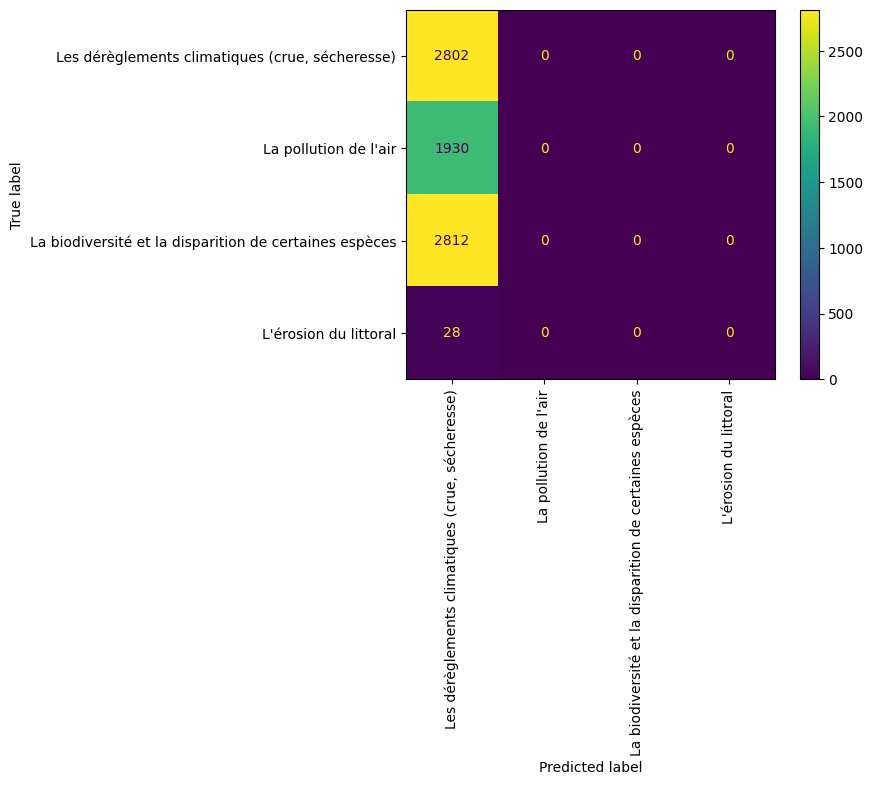

In [202]:
Y_output = model.predict([X_test_ok, X2_test_repeated1])
Y_prediction = np.argmax(Y_output, axis=1)

cm = confusion_matrix(np.argmax(Y_test_ok, axis=1), Y_prediction)
cm2 = ConfusionMatrixDisplay(cm, display_labels=liste)
cm2.plot(xticks_rotation="vertical")

In [249]:
import numpy as np 
import matplotlib.pyplot as plt 

pred = Y_prediction
  
pred0 = [np.argmax(ele) for ele in pred if np.argmax(ele)==0 ]
pred1 = [np.argmax(ele) for ele in pred if np.argmax(ele)==1 ]
pred2 = [np.argmax(ele) for ele in pred if np.argmax(ele)==2 ]
pred3 = [np.argmax(ele) for ele in pred if np.argmax(ele)==3 ]

train0 = [np.argmax(ele) for ele in Y_train_ok if np.argmax(ele)==0 ]
train1 = [np.argmax(ele) for ele in Y_train_ok if np.argmax(ele)==1 ]
train2 = [np.argmax(ele) for ele in Y_train_ok if np.argmax(ele)==2 ]
train3 = [np.argmax(ele) for ele in Y_train_ok if np.argmax(ele)==3 ]

dev0 = [np.argmax(ele) for ele in Y_dev_ok if np.argmax(ele)==0 ]
dev1 = [np.argmax(ele) for ele in Y_dev_ok if np.argmax(ele)==1 ]
dev2 = [np.argmax(ele) for ele in Y_dev_ok if np.argmax(ele)==2 ]
dev3 = [np.argmax(ele) for ele in Y_dev_ok if np.argmax(ele)==3 ]

test0 = [np.argmax(ele) for ele in Y_test_ok if np.argmax(ele)==0 ]
test1 = [np.argmax(ele) for ele in Y_test_ok if np.argmax(ele)==1 ]
test2 = [np.argmax(ele) for ele in Y_test_ok if np.argmax(ele)==2 ]
test3 = [np.argmax(ele) for ele in Y_test_ok if np.argmax(ele)==3 ]

label0 = [len(train0), len(dev0), len(test0), len(pred0), ]
label1 = [len(train1), len(dev1), len(test1), len(pred1), ]
label2 = [len(train2), len(dev2), len(test2), len(pred2)]
label3 = [len(train3), len(dev3), len(test3), len(pred3)]

X = ['Train', 'Dev', 'Test', 'Prédiction']

dico = {liste[0]: label0, liste[1]: label1, liste[2]: label2, liste[3]: label3}
print(dico)
x = np.arange(len(X))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for categorie, valeurs in dico.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, valeurs, width, label=categorie)
    ax.bar_label(rects, padding=4)
    multiplier += 1

ax.set_ylabel('Nombre de labels')
ax.set_title('Répartition des catégories dans les données et dans les prédictions')
ax.set_xticks(x + width, X)
ax.legend(loc='upper left')

plt.show()

{'Les dérèglements climatiques (crue, sécheresse)': [7572, 10028, 2379, 2802], "La pollution de l'air": [0, 6355, 1492, 1930], 'La biodiversité et la disparition de certaines espèces': [0, 7644, 2148, 2812], "L'érosion du littoral": [0, 201, 38, 28]}


In [ ]:
print()

## Résultats avec GRU

In [227]:
model = build_model(text_vectorizer)
model.fit(x=[X_train_ok, X2_train_repeated1], y=Y_train_ok, epochs=3, batch_size=32, validation_data=([X_dev_ok, X2_dev_repeated1], Y_dev_ok), verbose=1)

Epoch 1/3
758/758 [==============================] - 187s 245ms/step - loss: nan - accuracy: 0.3481 - val_loss: nan - val_accuracy: 0.3928
Epoch 2/3
758/758 [==============================] - 189s 250ms/step - loss: nan - accuracy: 0.4139 - val_loss: nan - val_accuracy: 0.3928
Epoch 3/3
758/758 [==============================] - 187s 247ms/step - loss: nan - accuracy: 0.4139 - val_loss: nan - val_accuracy: 0.3928


In [228]:
score = model.evaluate([X_test_ok, X2_test_repeated1], Y_test_ok )

print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

237/237 [==============================] - 11s 48ms/step - loss: nan - accuracy: 0.3700
Test loss: nan
Test accuracy: 0.37004753947257996


237/237 [==============================] - 11s 47ms/step


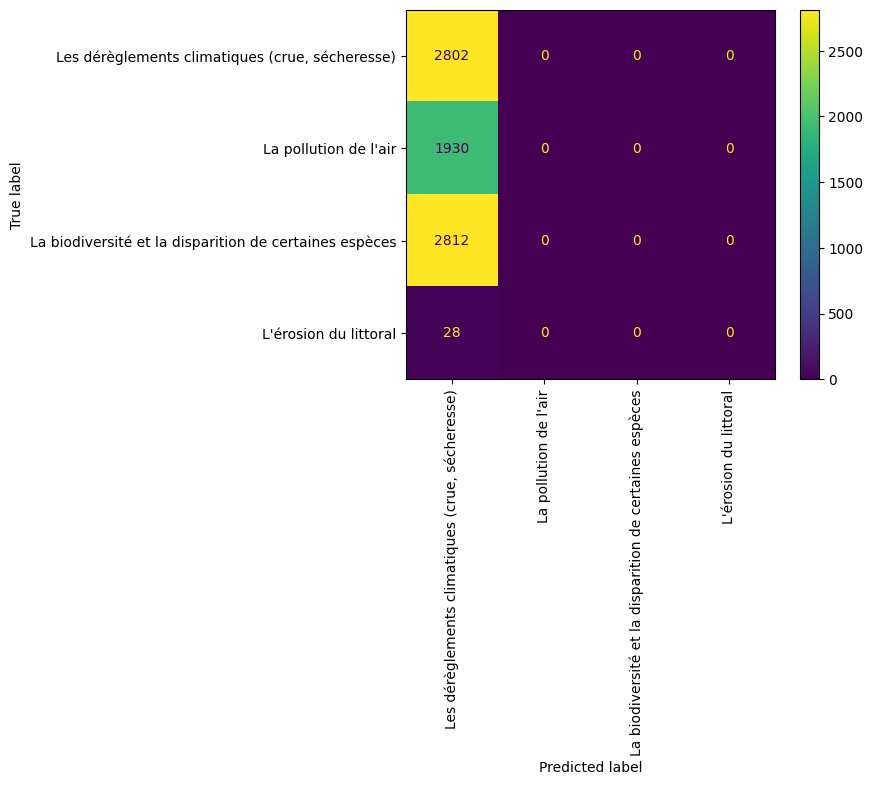

In [230]:
Y_output = model.predict([X_test_ok, X2_test_repeated1])
Y_prediction = np.argmax(Y_output, axis=1)

cm = confusion_matrix(np.argmax(Y_test_ok, axis=1), Y_prediction)
cm2 = ConfusionMatrixDisplay(cm, display_labels=liste)
cm2.plot(xticks_rotation="vertical")